In [132]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

%load_ext autoreload
%autoreload 2

from funs.plots import plot_stat_results, plot_feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read previously filtered data

In [114]:
df = pd.read_csv("../../data/processed/filtered_data.csv")

#### Split data into train and test sets

In [115]:
TARGET = 'is_fraud'

X = df[df.columns.difference([TARGET])]
y = df[TARGET]
X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

### XGBClassifier

In [159]:
params = {
    'objective':        'binary:logistic',
    'eval_metric':      'auc',
    'scale_pos_weight': 11,
    'learning_rate':    0.01,
    'n_estimators':     900,
    'max_depth':        6,
    'subsample':        0.8,
    'colsample_bytree': 0.8,
    'random_state':     42,
}

xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=900,
              n_jobs=None, num_parallel_tree=None, ...)

#### Model evaluation


Best Threshold: 0.61 with F1 score: 0.2545

Confusion Matrix:
[[91634 22763]
 [ 5738  4865]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9411    0.8010    0.8654    114397
           1     0.1761    0.4588    0.2545     10603

    accuracy                         0.7720    125000
   macro avg     0.5586    0.6299    0.5600    125000
weighted avg     0.8762    0.7720    0.8136    125000

ROC AUC: 0.7175


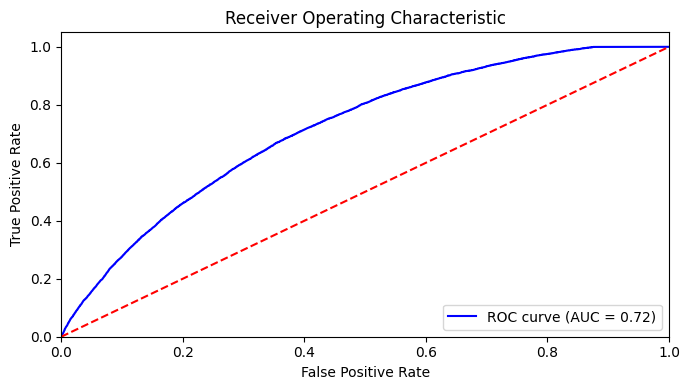

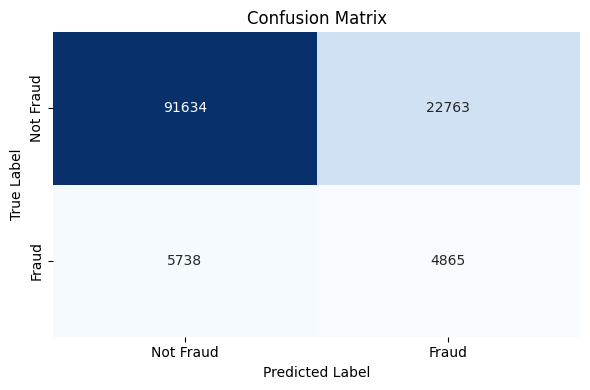

In [160]:
plot_stat_results(xgb, X_test, y_test)

#### Features importance

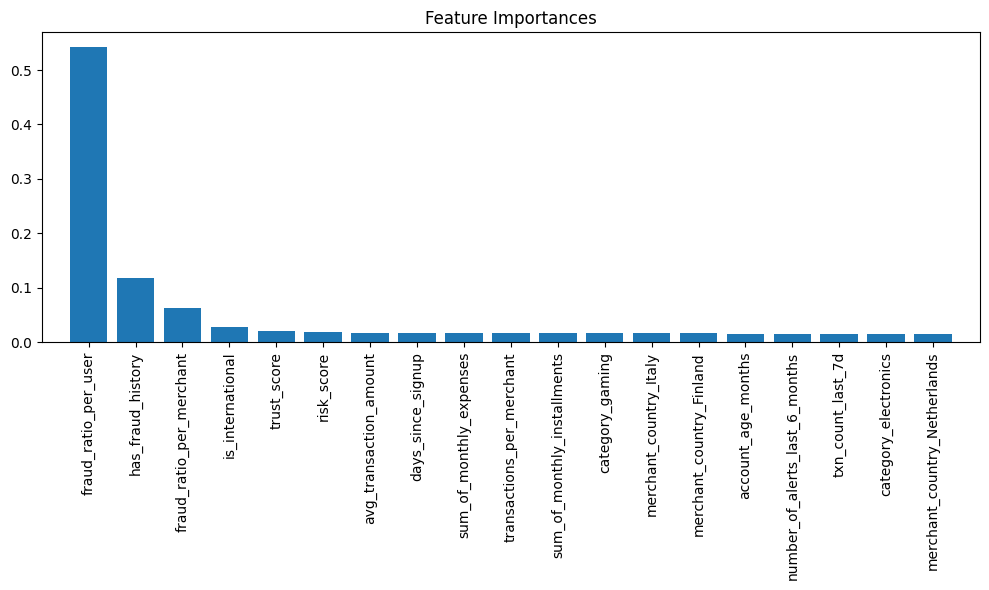

In [118]:
plot_feature_importance(xgb, X_train.columns)

### Logistic regression

In [119]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, random_state=42)
)
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100], 
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']
}
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1
)   

#### Grid search

In [120]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
best_model = grid_search.best_estimator_

Best parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


#### Model evaluation


Best Threshold: 0.11 with F1 score: 0.2559

Confusion Matrix:
[[90856 23541]
 [ 5593  5010]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9420    0.7942    0.8618    114397
           1     0.1755    0.4725    0.2559     10603

    accuracy                         0.7669    125000
   macro avg     0.5587    0.6334    0.5589    125000
weighted avg     0.8770    0.7669    0.8104    125000

ROC AUC: 0.7184


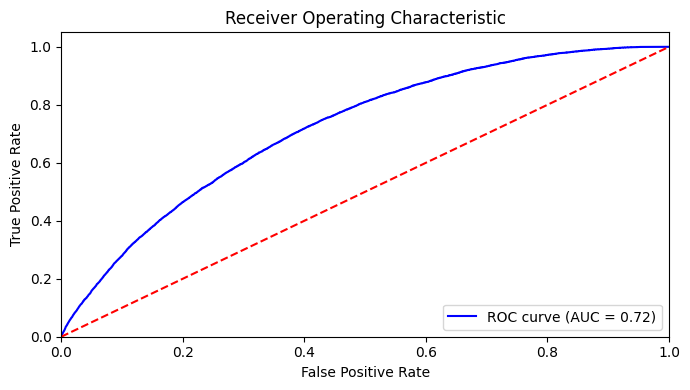

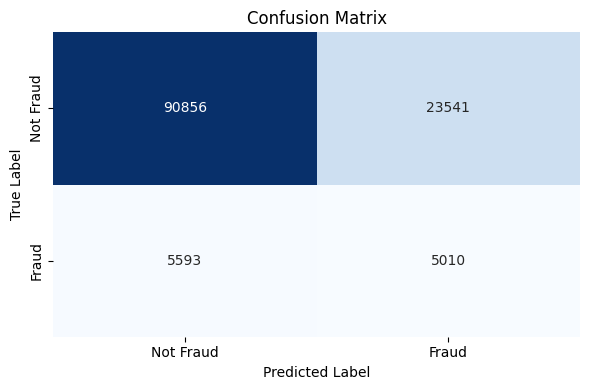

In [121]:
plot_stat_results(best_model, X_test, y_test)

### Dummy model

In [138]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

#### Model evaluation


Best Threshold: 0.00 with F1 score: 0.1564

Confusion Matrix:
[[     0 114397]
 [     0  10603]]

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    114397
           1     0.0848    1.0000    0.1564     10603

    accuracy                         0.0848    125000
   macro avg     0.0424    0.5000    0.0782    125000
weighted avg     0.0072    0.0848    0.0133    125000

ROC AUC: 0.5000


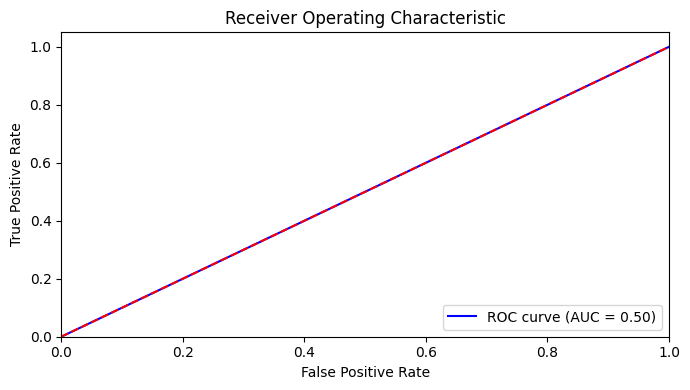

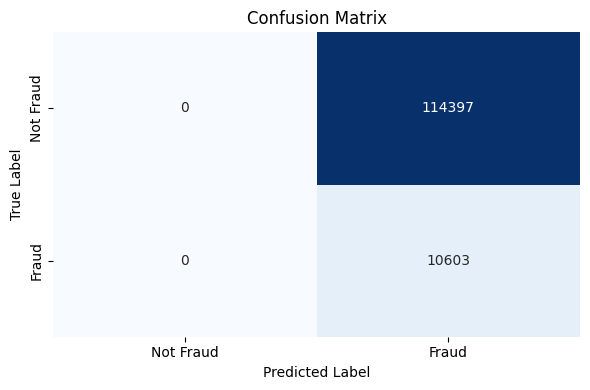

In [139]:
plot_stat_results(dummy_model, X_test, y_test)

### MLP Classifier

In [137]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=2000,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.001, batch_size=32, hidden_layer_sizes=(100, 50),
              learning_rate='adaptive', max_iter=2000, random_state=42)

#### Model evaluation


Best Threshold: 0.13 with F1 score: 0.2552

Confusion Matrix:
[[90544 23853]
 [ 5564  5039]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9421    0.7915    0.8603    114397
           1     0.1744    0.4752    0.2552     10603

    accuracy                         0.7647    125000
   macro avg     0.5583    0.6334    0.5577    125000
weighted avg     0.8770    0.7647    0.8089    125000

ROC AUC: 0.7197


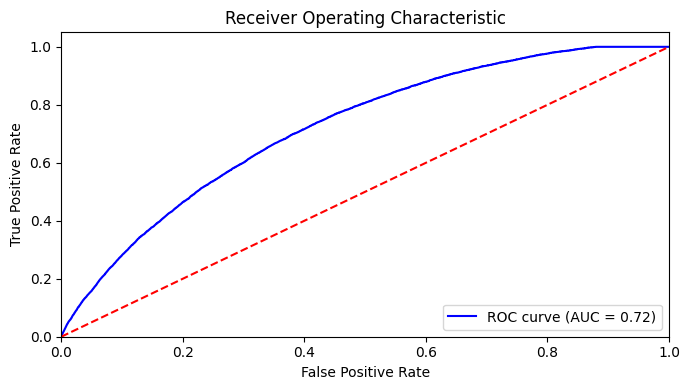

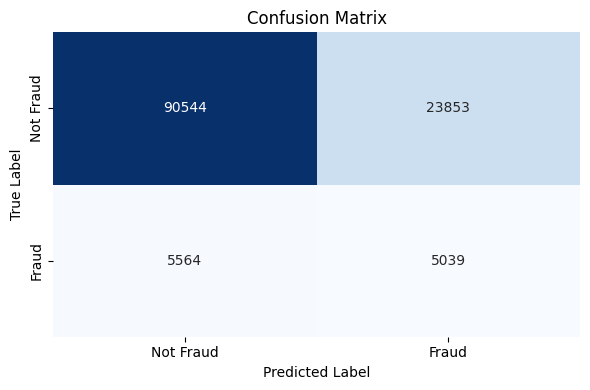

In [140]:
plot_stat_results(mlp, X_test_scaled, y_test)

### Random Forest Classifier

In [127]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

#### Model evaluation


Best Threshold: 0.59 with F1 score: 0.2499

Confusion Matrix:
[[91144 23253]
 [ 5768  4835]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9405    0.7967    0.8627    114397
           1     0.1721    0.4560    0.2499     10603

    accuracy                         0.7678    125000
   macro avg     0.5563    0.6264    0.5563    125000
weighted avg     0.8753    0.7678    0.8107    125000

ROC AUC: 0.7147


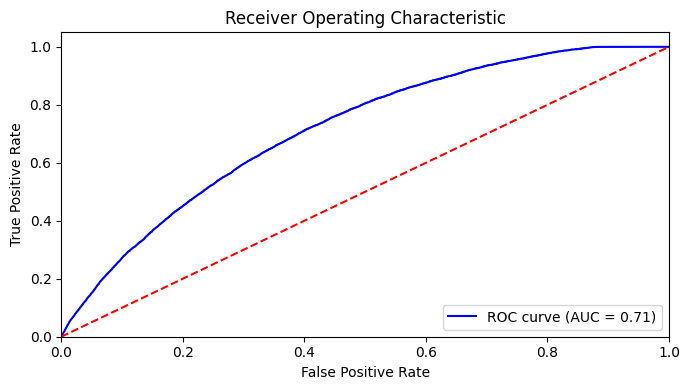

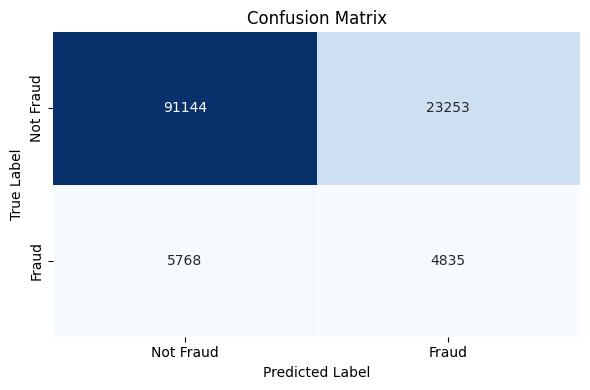

In [128]:
plot_stat_results(rf, X_test, y_test)

#### Features importance

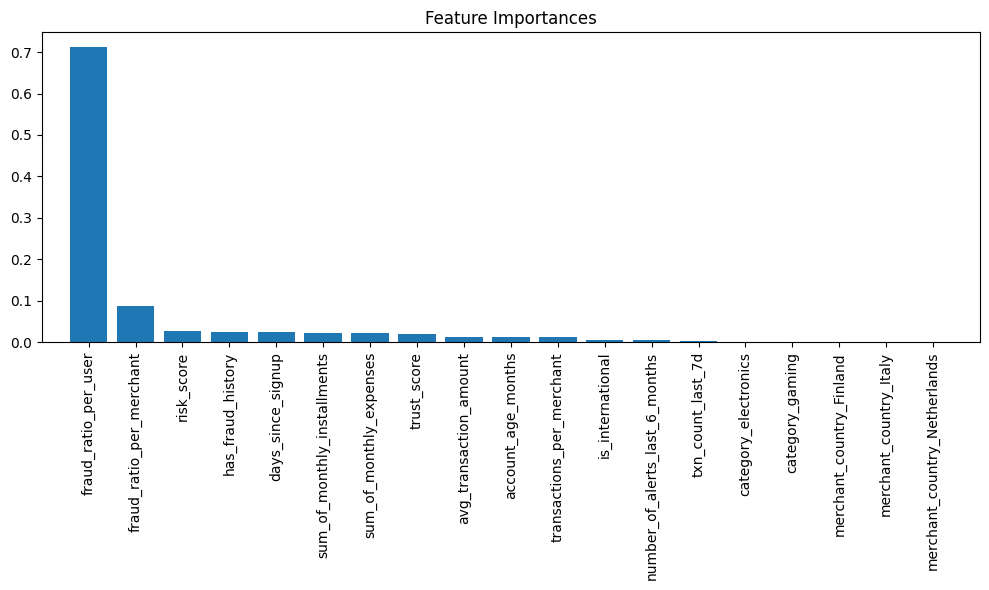

In [129]:
plot_feature_importance(rf, X_train.columns)